In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

import sklearn, sklearn.linear_model, sklearn.metrics, sklearn.pipeline,sklearn.ensemble

import matplotlib
import scipy.stats

matplotlib.rcParams.update({'font.size': 16})

In [2]:
#data_dir = '/s/project/mll/sergey/effect_prediction/MLM/'

data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/MLM/'

In [3]:
#3'UTR table

utr_table = pd.read_csv(data_dir + 'UTR_coords/GRCh38_3_prime_UTR_clean-sorted.bed', sep='\t',
                       header = None, names=['seq_start','seq_end','seq_name','strand'], usecols=[1,2,3,5])

In [4]:
utr_variants = pd.read_csv(data_dir + 'clinvar/clinvar.3utr.tsv', sep='\t', usecols = [0,1,2,3,4,5,6],
                           names=['chrom','pos','var_id','ref','alt','seq_name','label']) #ignore PhyloP columns here

In [5]:
utr_variants.pos = utr_variants.pos-1 #to 0-based

In [6]:
utr_variants = utr_variants[utr_variants.alt!='.'] #around 30 variants, not reliable

In [7]:
utr_variants = utr_variants[utr_variants.label.isin(('Pathogenic','Benign'))]

utr_variants.label = utr_variants.label.apply(lambda x: 1 if 'athogenic' in x else 0)

In [8]:
len_ref = utr_variants.ref.apply(len)
len_alt = utr_variants.alt.apply(len)

utr_variants.loc[(len_ref==1)&(len_alt==1),'vartype'] = 'SNP'
utr_variants.loc[(len_ref>1)&(len_alt==1),'vartype'] = 'DEL'
utr_variants.loc[(len_ref==1)&(len_alt>1),'vartype'] = 'INS'

utr_variants = utr_variants[~utr_variants.vartype.isna()] #not SNPs and not INDELs

/tmp/ipykernel_1873518/2012021764.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'SNP' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  utr_variants.loc[(len_ref==1)&(len_alt==1),'vartype'] = 'SNP'


In [9]:
utr_variants = utr_variants.merge(utr_table, how='left')

In [10]:
dist_to_utr_start = utr_variants.apply(lambda x: x.pos-x.seq_start if x.strand=='+' 
                                                       else  x.seq_end-x.pos, axis=1)

In [11]:
utr_variants = utr_variants[dist_to_utr_start<5000] #limit by the maximum sequence length on species-aware model

In [12]:
utr_variants.loc[:,'pos_rel'] = utr_variants.apply(lambda var: int(var.pos-var.seq_start) if var.strand=='+' else int(var.seq_end-var.pos-1), axis=1) # variat position w.r.t. sequence

In [13]:
for model in ('PhyloP100','PhyloP241'):

    with open(data_dir + f'PhyloP/{model}_3UTR.pickle', 'rb') as f:
        probas = dict(pickle.load(f))
        
    for var_idx, var in utr_variants.iterrows():
        if var.seq_name in probas.keys():
            if var.vartype=='SNP':
                utr_variants.at[var_idx,model] = probas[var.seq_name][var.pos_rel]
            else:
                if var.vartype=='INS':
                    left, right = var.pos_rel-2, var.pos_rel+2
                else:
                    if var.strand=='+':
                        left, right = var.pos_rel, var.pos_rel+len(var.ref)
                    else:
                        left, right = var.pos_rel-len(var.ref), var.pos_rel
                utr_variants.at[var_idx,model] = np.mean(probas[var.seq_name][left:right])

/home/icb/sergey.vilov/miniconda3/envs/mlm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/icb/sergey.vilov/miniconda3/envs/mlm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/icb/sergey.vilov/miniconda3/envs/mlm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/icb/sergey.vilov/miniconda3/envs/mlm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [14]:
mapping = {'A':0,'C':1,'G':2,'T':3}

In [15]:
human_fasta = data_dir + 'fasta/240_species/species/Homo_sapiens.fa' #3'UTR on hegative strand should already be reversed

human_utr = defaultdict(str)

with open(human_fasta, 'r') as f:
    for line in f:
        if line.startswith('>'):
            seq_name = line[1:].split(':')[0]
        else:
            human_utr[seq_name] += line.rstrip().upper()

In [16]:
def add_model_res(model_name, model_probas):
    
    with open(model_probas, 'rb') as f:
        probas = dict(pickle.load(f))
        
    for var_idx, var in utr_variants.iterrows():
        if var.seq_name in probas.keys():
            if var.vartype=='SNP':
                utr_variants.at[var_idx, model_name+'_alt'] = probas[var.seq_name][var.pos_rel, mapping[var.alt]]
                utr_variants.at[var_idx, model_name+'_ref'] = probas[var.seq_name][var.pos_rel, mapping[var.ref]]
            else:
                if var.vartype=='INS':
                    left, right = var.pos_rel-2, var.pos_rel+2
                else:
                    if var.strand=='+':
                        left, right = var.pos_rel, var.pos_rel+len(var.ref)
                    else:
                        left, right = var.pos_rel-len(var.ref), var.pos_rel
                ref_score = []
                seq = human_utr[var.seq_name]
                for pos_rel in range(max(left,0),min(right,len(seq))):
                    ref_score.append(probas[var.seq_name][pos_rel, mapping[seq[pos_rel]]]) 
                    #ref_score.append(np.max(probas[var.seq_name][pos_rel])) 
                utr_variants.at[var_idx, model_name+'_ref'] = np.mean(ref_score)

In [64]:
add_model_res('mlm_spaw_tscale', data_dir + 'motif_predictions/species_aware_tempscale/probas.pickle')
add_model_res('mlm_spaw', data_dir + 'motif_predictions/species_aware/probas.pickle')

/home/icb/sergey.vilov/miniconda3/envs/mlm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/icb/sergey.vilov/miniconda3/envs/mlm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [65]:
df = utr_variants[(~utr_variants.PhyloP100.isna())&(~utr_variants.mlm_spaw_alt.isna())]

In [66]:
df['score'] = 1-df.mlm_spaw_tscale_alt
df['score_old'] = 1-df.mlm_spaw_alt

/tmp/ipykernel_1873518/4169039756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 1-df.mlm_spaw_tscale_alt
/tmp/ipykernel_1873518/4169039756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score_old'] = 1-df.mlm_spaw_alt


In [67]:
sklearn.metrics.roc_auc_score(df.label, df.PhyloP100)

0.8932651265984599

In [68]:
dnabert_res = pd.read_csv(data_dir + '/clinvar/dnabert/default/roc.tsv', sep='\t')

ROC AUC MLM P(alt): 0.56
ROC AUC MLM P(alt), T scaling: 0.73
ROC AUC DNABERT P(alt): 0.49
ROC AUC DNABERT P(alt), T scaling: 0.55


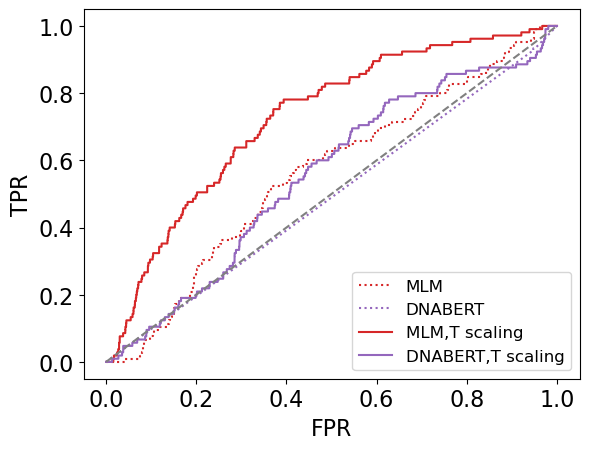

In [69]:
fig, ax = plt.subplots()


fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.score_old)
ax.plot(fpr,tpr, label='MLM',linestyle='dotted', color='tab:red')

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(dnabert_res.label, dnabert_res.score_old)
ax.plot(fpr,tpr, label='DNABERT',linestyle='dotted', color='tab:purple')

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.score)
ax.plot(fpr,tpr, label='MLM,T scaling', color='tab:red')

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(dnabert_res.label, dnabert_res.score)
ax.plot(fpr,tpr, label='DNABERT,T scaling', color='tab:purple')

ax.plot(fpr,fpr,color='gray',linestyle='--')

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend(fontsize=12)

print(f'ROC AUC MLM P(alt): {sklearn.metrics.roc_auc_score(df.label, df.score_old):.2}')
print(f'ROC AUC MLM P(alt), T scaling: {sklearn.metrics.roc_auc_score(df.label, df.score):.2}')

print(f'ROC AUC DNABERT P(alt): {sklearn.metrics.roc_auc_score(dnabert_res.label, dnabert_res.score_old):.2}')
print(f'ROC AUC DNABERT P(alt), T scaling: {sklearn.metrics.roc_auc_score(dnabert_res.label, dnabert_res.score):.2}')

ROC AUC MLM P(alt), T scaling: 0.73
ROC AUC PhyloP100: 0.89
ROC AUC PhyloP241: 0.77


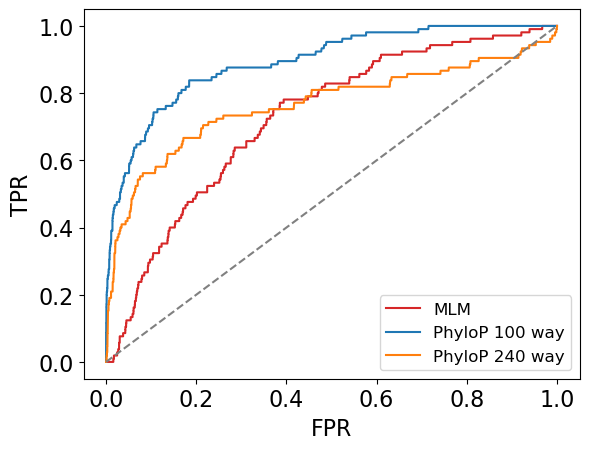

In [70]:
fig, ax = plt.subplots()

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.score)
ax.plot(fpr,tpr, label='MLM', color='tab:red')

#fpr, tpr, roc_thr = sklearn.metrics.roc_curve(dnabert_res.label, dnabert_res.score)
#ax.plot(fpr,tpr, label='DNABERT P(alt),T scaling', color='tab:purple')

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.PhyloP100)
ax.plot(fpr,tpr, label='PhyloP 100 way')

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.PhyloP241)
ax.plot(fpr,tpr, label='PhyloP 240 way')

ax.plot(fpr,fpr,color='gray',linestyle='--')

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend(fontsize=12)

print(f'ROC AUC MLM P(alt), T scaling: {sklearn.metrics.roc_auc_score(df.label, df.score):.2}')
#print(f'ROC AUC DNABERT P(alt), T scaling: {sklearn.metrics.roc_auc_score(dnabert_res.label, dnabert_res.score):.2}')

print(f'ROC AUC PhyloP100: {sklearn.metrics.roc_auc_score(df.label, df.PhyloP100):.2}')
print(f'ROC AUC PhyloP241: {sklearn.metrics.roc_auc_score(df.label, df.PhyloP241):.2}')

In [71]:
def logistic_regression_cv(X,y):

    K_fold = sklearn.model_selection.KFold(n_splits=10)
    
    y_pred = np.zeros((len(y),))

    pipe_LR = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), 
                                                     sklearn.linear_model.LogisticRegressionCV(cv=10, Cs=10.**np.arange(-10,10)),)

    #pipe_LR = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.svm.SVC(probability=True))

    pipe_LR = sklearn.ensemble.GradientBoostingClassifier()
    
    for train_index, test_index in K_fold.split(X):
        
        pipe_LR.fit(X[train_index],y[train_index])
        
        y_pred[test_index] = pipe_LR.predict_proba(X[test_index])[:,1]
        
    return y_pred

X, y = df[['score','PhyloP100']].values, df.label.values
df['MLM_PhyloP100'] = logistic_regression_cv(X,y)

X, y = df[['score','PhyloP241']].values, df.label.values
df['MLM_PhyloP241'] = logistic_regression_cv(X,y)

/tmp/ipykernel_1873518/1334951487.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MLM_PhyloP100'] = logistic_regression_cv(X,y)
/tmp/ipykernel_1873518/1334951487.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MLM_PhyloP241'] = logistic_regression_cv(X,y)


ROC AUC PhyloP100: 0.89
ROC AUC MLM + PhyloP 100: 0.86
ROC AUC PhyloP241: 0.77
ROC AUC MLM + PhyloP 241: 0.76


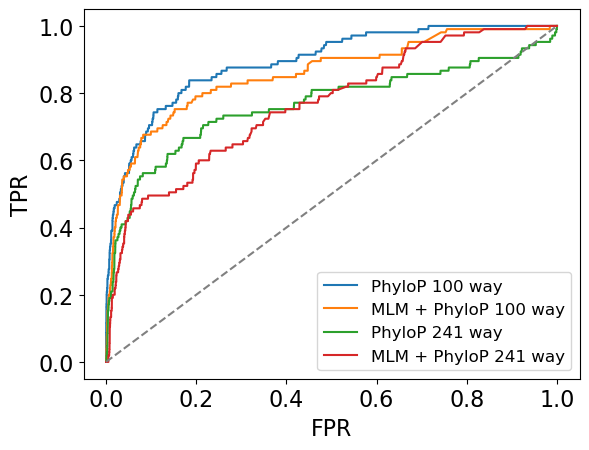

In [72]:
fig, ax = plt.subplots()

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.PhyloP100)
ax.plot(fpr,tpr, label='PhyloP 100 way')

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.MLM_PhyloP100)
ax.plot(fpr,tpr, label='MLM + PhyloP 100 way')

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.PhyloP241)
ax.plot(fpr,tpr, label='PhyloP 241 way')

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.MLM_PhyloP241)
ax.plot(fpr,tpr, label='MLM + PhyloP 241 way')

ax.plot(fpr,fpr,color='gray',linestyle='--')

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend(fontsize=12)

print(f'ROC AUC PhyloP100: {sklearn.metrics.roc_auc_score(df.label, df.PhyloP100):.2}')
print(f'ROC AUC MLM + PhyloP 100: {sklearn.metrics.roc_auc_score(df.label, df.MLM_PhyloP100):.2}')

print(f'ROC AUC PhyloP241: {sklearn.metrics.roc_auc_score(df.label, df.PhyloP241):.2}')
print(f'ROC AUC MLM + PhyloP 241: {sklearn.metrics.roc_auc_score(df.label, df.MLM_PhyloP241):.2}')

In [73]:
df = utr_variants[(utr_variants.vartype!='SNP')&(~utr_variants.mlm_spaw_tscale_ref.isna())&(~utr_variants.PhyloP100.isna())]

ROC AUC PhyloP100: 0.67
ROC AUC MLM: 0.82
ROC AUC PhyloP241: 0.71


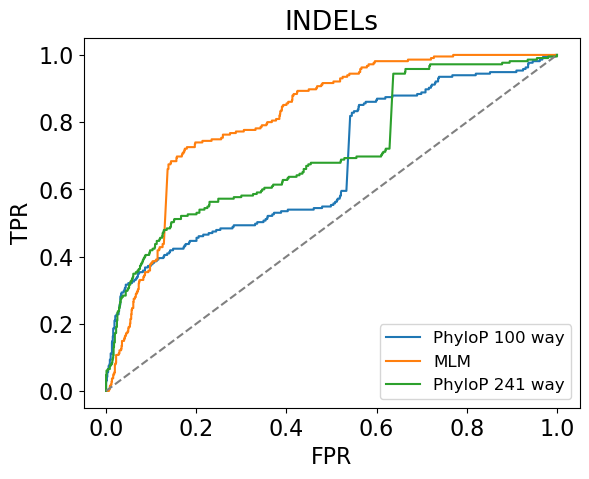

In [75]:
fig, ax = plt.subplots()

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.PhyloP100)
ax.plot(fpr,tpr, label='PhyloP 100 way')

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, -df.mlm_spaw_tscale_ref)
ax.plot(fpr,tpr, label='MLM')

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.PhyloP241)
ax.plot(fpr,tpr, label='PhyloP 241 way')

#fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.MLM_PhyloP241)
#ax.plot(fpr,tpr, label='MLM + PhyloP 241 way')

ax.plot(fpr,fpr,color='gray',linestyle='--')


ax.set_title('INDELs')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend(fontsize=12)

print(f'ROC AUC PhyloP100: {sklearn.metrics.roc_auc_score(df.label, df.PhyloP100):.2}')
print(f'ROC AUC MLM: {sklearn.metrics.roc_auc_score(df.label, -df.mlm_spaw_tscale_ref):.2}')

print(f'ROC AUC PhyloP241: {sklearn.metrics.roc_auc_score(df.label, df.PhyloP241):.2}')


In [23]:
PhyloP_df = pd.read_csv(data_dir + 'UTR_coords/PhyloP100_PhyloP241_intersect.tsv.gz', usecols=[2,3],
                       names=['PhyloP100','PhyloP241'], sep=' ',skiprows=lambda x:x%100!=0) #PhyloP100 and PhyloP241 scores in 3'UTR regions

Text(0.5, 0, 'PhyloP 100 way')

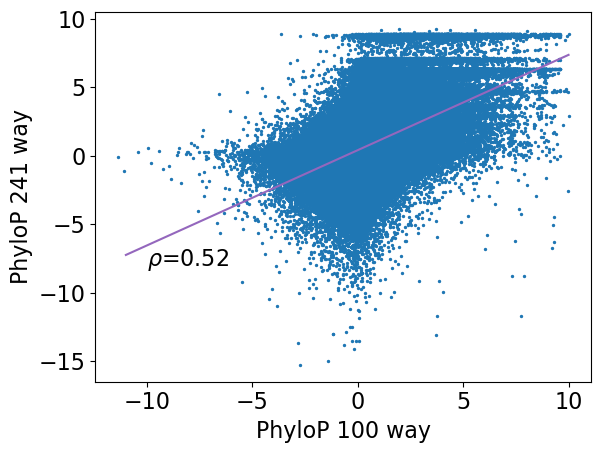

In [24]:
fig, ax = plt.subplots()

scatter = ax.scatter(PhyloP_df.PhyloP100,PhyloP_df.PhyloP241, s=2)
    
pearson_r, p_value = scipy.stats.pearsonr(PhyloP_df.PhyloP100,PhyloP_df.PhyloP241)
        
k, b = np.polyfit(PhyloP_df.PhyloP100,PhyloP_df.PhyloP241,deg=1)
    
    
ax.plot(np.linspace(-11,10), k*np.linspace(-11,10)+b, c='tab:purple')
    
ax.text(x=-10, y=-8, s=r"$\rho$"+f'={pearson_r:.2f}', fontsize=16)

ax.set_ylabel('PhyloP 241 way')
ax.set_xlabel('PhyloP 100 way')